# Camera Setup

In [ ]:
import cv2
import cv2.aruco as aruco
import os
import numpy as np
import subprocess

# Camera 0 refers to top camera, Camera 1 refers to bottom camera
# Ensure camera port ids are correct
port_ids = [2, 0]
cam0_device = f"/dev/video{port_ids[0]}"
cam1_device = f"/dev/video{port_ids[1]}"

# Ensure proper camera configurations
cam0_focus_value = 35
cam1_focus_value = 75
config_commands = {cam0_device: [
                    f"v4l2-ctl -d {cam0_device} -c focus_automatic_continuous=0",
                    f"v4l2-ctl -d {cam0_device} -c auto_exposure=3",
                    f"v4l2-ctl -d {cam0_device} -c focus_absolute={cam0_focus_value}",
                    # f"v4l2-ctl -d {device} -c exposure_time_absolute=333",
                    # f"v4l2-ctl -d {device} -c gain=0",
                    # f"v4l2-ctl -d {device} -c white_balance_automatic=0",
                    # f"v4l2-ctl -d {device} -c white_balance_temperature=4675",
                    # f"v4l2-ctl -d {device} -c brightness=128",
                    # f"v4l2-ctl -d {device} -c contrast=128",
                    # f"v4l2-ctl -d {device} -c saturation=128",
                    ],
                cam1_device: [
                    f"v4l2-ctl -d {cam1_device} -c focus_automatic_continuous=0",
                    f"v4l2-ctl -d {cam1_device} -c auto_exposure=3",
                    f"v4l2-ctl -d {cam1_device} -c focus_absolute={cam1_focus_value}",
                    # f"v4l2-ctl -d {device} -c exposure_time_absolute=333",
                    # f"v4l2-ctl -d {device} -c gain=0",
                    # f"v4l2-ctl -d {device} -c white_balance_automatic=0",
                    # f"v4l2-ctl -d {device} -c white_balance_temperature=4675",
                    # f"v4l2-ctl -d {device} -c brightness=128",
                    # f"v4l2-ctl -d {device} -c contrast=128",
                    # f"v4l2-ctl -d {device} -c saturation=128",
                    ]
                }

def configure_camera(devices, config_commands):
    for device in devices:

        print(f"Configuring camera on {device}...")

        for command in config_commands[device]:
            subprocess.run(command, shell=True, check=True)

        print("Camera configuration complete!")

# Grab some test images of catheter tip

In [ ]:
# Collect images of calibration board in both cameras frames for stereo extrinsic calibration
import cv2
import datetime
import os

output_dir = f"../tip_pose_images"
os.makedirs(output_dir, exist_ok=True)

# Make sure cameras are configures
# configure_camera([cam0_device, cam1_device], config_commands) # Uncomment to use default configs
cap0 = cv2.VideoCapture(port_ids[0], cv2.CAP_V4L2)
cap1 = cv2.VideoCapture(port_ids[1], cv2.CAP_V4L2)
frame_count = 0
while True:
    # Read frames from both cameras
    ret0, frame0 = cap0.read()
    ret1, frame1 = cap1.read()

    if not ret0 or not ret1:
        print("Error: One or both frames could not be read.")
        break

    # Display both camera feeds with timestamps
    # timestamp = datetime.now().strftime("%H:%M:%S.%f")
    # cv2.putText(frame1, f"Cam1 - {timestamp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(frame2, f"Cam2 - {timestamp}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Combine and display both frames
    combined = cv2.hconcat([frame0, frame1])
    cv2.imshow("Camera 0 (top) + Camera 1 (side)", combined)

    key = cv2.waitKey(1) & 0xFF

    if key == 27:  # ESC key to exit
        break
    elif key == ord(' '):  # Space key to capture images
        img0_path = f"{output_dir}/cam0_{frame_count}.png"
        img1_path = f"{output_dir}/cam1_{frame_count}.png"
        cv2.imwrite(img0_path, frame0)
        cv2.imwrite(img1_path, frame1)
        print(f"Captured images:\n - {img0_path}\n - {img1_path}")
        frame_count += 1

# Release both cameras and close windows
cap0.release()
cap1.release()
cv2.destroyAllWindows()

# Segmentation by manual point prompt

In [ ]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from matplotlib import pyplot as plt
import glob
import pickle

# Mouse callback function
def on_mouse(event, x, y, flags, param):
    global clicked_points, mode
    if event == cv2.EVENT_LBUTTONDOWN:
        label = 1 if mode == 'f' else 0
        clicked_points.append((x, y, label))
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.circle(image, (x, y), 5, color, -1)
        cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image)
        print(f"Clicked point: x={x}, y={y}, label={label}")

# Load SAM model
checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
# sam.to("cuda" if torch.cuda.is_available() else "cpu")
sam.to("cpu")
sam_predictor = SamPredictor(sam)

# Loop over images in director
dir = "../tip_pose_images"
cam0_img_path = sorted(glob.glob(f"{dir}/cam0_*.png"))
cam1_img_path = sorted(glob.glob(f"{dir}/cam1_*.png"))
mask_dir = f"{dir}/masks"

for cam_num, (img0_path, img1_path) in enumerate(zip(cam0_img_path, cam1_img_path)):
    # Read images
    img0 = cv2.imread(img0_path)
    img1 = cv2.imread(img1_path)

    # Convert to RGB
    img0_rgb = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = img0.shape

    for image_num, image in enumerate([img0, img1]):

        sam_predictor.set_image(image)

       # Initialize global variables
        clicked_points = []
        mode = 'f'  # Start with foreground mode

        cv2.imshow("Select Points (f: foreground, b: background, ESC: done)", image)
        cv2.setMouseCallback("Select Points (f: foreground, b: background, ESC: done)", on_mouse)

        while True:
            key = cv2.waitKey(0) & 0xFF
            if key == 27:  # ESC to exit
                break
            elif key == ord('f'):
                mode = 'f'
                print("Switched to foreground mode.")
            elif key == ord('b'):
                mode = 'b'
                print("Switched to background mode.")

        cv2.destroyAllWindows()

        # Separate points into foreground and background
        fg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 1], dtype=np.float32)
        bg_coords = np.array([[x, y] for x, y, label in clicked_points if label == 0], dtype=np.float32)

        # Predict the mask
        with torch.no_grad():
            masks, scores, logits = sam_predictor.predict(
                point_coords=np.vstack((fg_coords, bg_coords)),
                point_labels=np.array([1] * len(fg_coords) + [0] * len(bg_coords)),
                multimask_output=False
            )

        # Save segmentation results
        segmentation_results = {
            "masks": masks,
            "scores": scores,
            "logits": logits
        }
        with open(f"{dir}/segmentation_results/cam{cam_num}_{image_num}.pkl", "wb") as f:
            pickle.dump(segmentation_results, f)

        # Display and save the mask overlayed on the original image
        mask = masks[0].astype(np.uint8) * 255
        # Create a red mask overlay with transparency
        mask_colored = np.zeros_like(image)
        mask_colored[:, :, 2] = mask  # Red channel
        overlay = image.copy()
        alpha = 0.5
        overlay[mask > 0] = (1 - alpha) * overlay[mask > 0] + alpha * np.array([0, 0, 255])
        cv2.imshow("Segmented Mask Overlay", overlay)
        cv2.imwrite(f"{mask_dir}/cam{cam_num}_{image_num}.png", overlay)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


# Shape from Silhouette

## Create voxel projection lookup table

In [38]:
import numpy as np
import cv2
import pickle

# Define voxel grid
VOXEL_SIZE = 0.01  # 1 mm voxel size
N_X = 3
N_Y = 3
N_Z = 3
voxel_map = np.zeros((N_X, N_Y, N_Z), dtype=np.uint8)
origin = np.array([(N_X - 1) / 2, (N_Y - 1) / 2, 0]) * VOXEL_SIZE
voxel_coordinates = np.mgrid[0:N_X, 0:N_Y, 0:N_Z].reshape(3, -1).T * VOXEL_SIZE - origin
# print(voxel_coordinates)

# def voxel_index_to_cartesian(i, j, k):
#     '''Convert voxel indices to 3D coordinates in the voxel grid.
#     Coordinate frame origin is at center of x, y, and at 0 for z.
#     '''
#     x_coord = (i - (N_X - 1) / 2) * VOXEL_SIZE
#     y_coord = (j - (N_Y - 1) / 2) * VOXEL_SIZE
#     z_coord = k * VOXEL_SIZE
#     return np.array([x_coord, y_coord, z_coord])

# Load camera calibration data
with open("../camera_calibration/05-08-25/camera_calib_data.pkl", "rb") as f:
    camera_calib_data = pickle.load(f)

# Define lookup table for two cameras voxel projection to image plane
voxel_lookup_table = np.zeros((2, N_X*N_Y*N_Z, 2), dtype=np.float32)

for cam_num in range(2):
        # Get camera parameters
        K = camera_calib_data[f"cam{cam_num}"]["intrinsics"]["K"] # Camera intrinsic matrix
        d = camera_calib_data[f"cam{cam_num}"]["intrinsics"]["d"] # Distortion coefficients
        R = camera_calib_data[f"cam{cam_num}"]["extrinsics"]["R"] # Extrinsic camera-world rotation matrix
        T = camera_calib_data[f"cam{cam_num}"]["extrinsics"]["T"] # Extrinsic camera-world translation vector
        rvec, _ = cv2.Rodrigues(R) # Rotation vector from rotation matrix
        image_coordinates, _ = cv2.projectPoints(voxel_coordinates, rvec, T, K, d)
            
        voxel_lookup_table[cam_num, :, :] = image_coordinates.reshape(-1, 2)

# Voxel Carving

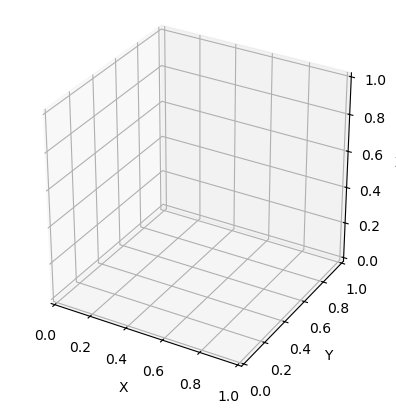

In [39]:
import cv2
import numpy as np
import glob
import os
import pickle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dir = "../tip_pose_images"
# cam0_path = sorted(glob.glob(f"{dir}/cam0_*.pkl"))
# cam1_path = sorted(glob.glob(f"{dir}/cam1_*.pkl"))
cam0_file = f"{dir}/segmentation_results/cam0_0.pkl"
cam1_file = f"{dir}/segmentation_results/cam1_0.pkl"

# for cam0_file, cam1_file in zip(cam0_path, cam1_path):

with open(cam0_file, "rb") as f:
    cam0_segmentation_results = pickle.load(f)
with open(cam1_file, "rb") as f:
    cam1_segmentation_results = pickle.load(f)
cam0_mask = cam0_segmentation_results["masks"][0]
cam1_mask = cam1_segmentation_results["masks"][0]

# Voxel carving
for index, (i, j, k) in enumerate(np.ndindex(N_X, N_Y, N_Z)):
    cam0_voxel_coords = voxel_lookup_table[0, index, :]
    cam1_voxel_coords = voxel_lookup_table[1, index, :]

    # Check if the voxel is visible in both cameras
    if cam0_mask[int(cam0_voxel_coords[1]), int(cam0_voxel_coords[0])] > 0 and \
        cam1_mask[int(cam1_voxel_coords[1]), int(cam1_voxel_coords[0])] > 0:
        voxel_map[i, j, k] = 1


# Visualize voxel map

# Extract the coordinates of occupied voxels
occupied_voxels = np.argwhere(voxel_map == 1)
occupied_points = occupied_voxels * VOXEL_SIZE - origin

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(occupied_points[:, 0], occupied_points[:, 1], occupied_points[:, 2], c='r', marker='o')

# Set labels and aspect ratio
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

plt.show()